In [4]:
import numpy as np
from numpy.random import normal as Gauss
from numpy.random import randn
import matplotlib.pyplot as plt
import h5py
%matplotlib inline



In [2]:
class DatasetLoader():
    
    def __init__(self, path):
        self.path = path 
        
    def load(self):
        X_train,y_train,X_test,y_test = self.get_data(self.path)
        X_train = self.normalize(self.flatten_images(X_train))
        X_test = self.normalize(self.flatten_images(X_test))
        
        return X_train,y_train,X_test,y_test
    
    def flatten_images(self,X):
        x = X.reshape(X.shape[0],-1)      
        return x

    def normalize(self,X):
        return X/255
    
    def get_info(self):        
        print(f"Training images has a shape  : {X_train.shape}  and contains {X_train.shape[0]} training images with 32x32 pixel" )
        print(f"Training labels has a shape  : {y_train.shape}")
        print(f"Testing images  has a shape  : {X_test.shape}   and contains {X_test.shape[0]} testing images with 32x32 pixel" )
        print(f"Testing labels  has a shape  : {y_test.shape}") 
        
        
        
    def get_data(self,path) -> tuple :
        """
        Given the path of the dataset, return
        training and testing images with respective
        labels.
        """
    
        with h5py.File(path,'r') as F:
            # Names variable contains the names of training and testing file 
            names = list(F.keys())

            X_train = np.array(F[names[2]][:])
            y_train = np.array(F[names[3]][:])
            X_test = np.array(F[names[0]][:])
            y_test = np.array(F[names[1]][:])

            y_train = y_train.reshape(y_train.shape[0],1)
            y_test = y_test.reshape(y_test.shape[0],1)
            
            y_train[y_train==0]=-1
            y_test[y_test==0]=-1

        return X_train,y_train,X_test,y_test 
    
path = 'assign2_data1.h5'
data = DatasetLoader(path)
X_train,y_train,X_test,y_test = data.load() 

In [3]:
data.get_info()  

Training images has a shape  : (1900, 1024)  and contains 1900 training images with 32x32 pixel
Training labels has a shape  : (1900, 1)
Testing images  has a shape  : (1000, 1024)   and contains 1000 testing images with 32x32 pixel
Testing labels  has a shape  : (1000, 1)


In [5]:
class TwoLayerNetwork:
    
    def __init__(self,input_size = X_train.shape,batch_size = 19 ,n_neurons = 76 , mean = 0,std = 1, lr = 1e-1, distribution = 'Xavier'):
        np.random.seed(15)
        self.lr = lr                              
        self.mse_train = {}
        self.mce_train = {}
        self.mse_test = {}
        self.mce_test = {}
        
        self.sample_size = input_size[0]
        self.feature_size = input_size[1]
        self.batch_size = batch_size
        self.n_neurons = n_neurons
        self.mean,self.std = mean,std
        
        self.dist = distribution
        
        
        self.n_update = round((self.sample_size/self.batch_size))
        
        self.W1_size = self.feature_size,self.n_neurons        
        self.W2_size = self.n_neurons,1
        
        self.B1_size = 1,self.n_neurons
        self.B2_size = 1,1
        
        self.B1 = Gauss(loc = self.mean, scale = self.std, size = (self.B1_size)) * 0.01
        self.B2 = Gauss(loc = self.mean, scale = self.std, size = (self.B2_size)) * 0.01  
               
        
        self.he_scale1 = np.sqrt(2/self.feature_size)
        self.he_scale2 = np.sqrt(2/self.n_neurons)
        self.xavier_scale1 = np.sqrt(2/(self.feature_size+self.n_neurons))
        self.xavier_scale2 = np.sqrt(2/(self.n_neurons+1))      
        
        

        if (self.dist == 'Zero') :
            self.W1 = np.zeros((self.W1_size))
            self.W2 = np.zeros((self.W2_size))

        elif (self.dist == 'Gauss'):
            self.W1 = Gauss(loc = self.mean, scale = self.std, size = (self.W1_size))* 0.01
            self.W2 = Gauss(loc = self.mean, scale = self.std, size = (self.W2_size))* 0.01

        elif (self.dist == 'He'):
            self.W1 = randn(self.W1_size[0],self.W1_size[1]) * self.he_scale1
            self.W2 = randn(self.W2_size[0],self.W2_size[1]) * self.he_scale2

        elif (self.dist == 'Xavier'):

            self.W1 = randn(self.W1_size[0],self.W1_size[1]) * self.xavier_scale1
            self.W2 = randn(self.W2_size[0],self.W2_size[1]) * self.xavier_scale2 
            

        
    def forward(self,X):        
        
        Z1 = (X @ self.W1)  + self.B1 
        A1 = np.tanh(Z1)        
        Z2 = (A1 @ self.W2) + self.B2
        A2 = np.tanh(Z2)
               
        return {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    
    
    def tanh(self,X):        
        return (np.exp(X) - np.exp(-X))/(np.exp(X) + np.exp(-X))

    def tanh_der(self,X):        
        return  1-(np.tanh(X)**2)
    
    def backward(self,outs, X, Y):
        m = (self.batch_size) 
        
        Z1 = outs['Z1']
        A1 = outs['A1']
        Z2 = outs['Z2']
        A2 = outs['A2']
        
        dZ2 = (A2-Y)* self.tanh_der(Z2)
        dW2 = (1/m) * (A1.T @ dZ2)
        dB2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True) 
        
        dZ1 = (dZ2 @ self.W2.T) * self.tanh_der(Z1)
        dW1 = (1/m) * (X.T @ dZ1)
        dB1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

        
        return {"dW1": dW1, "dW2": dW2,
                "dB1": dB1, "dB2": dB2}  
        
    def Loss(self,pred,y_true):
        
        mse = np.square(pred-y_true).mean()
        
        pred[pred>=0]=1 
        pred[pred<0]=-1         
        
        mce = (pred == y_true).mean()
        
        return {'MSE':mse,'MCE':mce}
      
       
    def SGD(self,grads):        
        self.W1 -= self.lr * grads['dW1']     
        self.W2 -= self.lr * grads['dW2']
        self.B1 -= self.lr * grads['dB1']     
        self.B2 -= self.lr * grads['dB2']
        
    def fit(self,X,Y,X_test,y_test,epochs = 300,verbose=True):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
        
        m = self.batch_size
        
        for epoch in range(epochs):
            perm = np.random.permutation(self.sample_size)          
            
            for i in range(self.n_update):
                
                
                batch_start = i * m
                batch_finish = (i+1) * m
                index = perm[batch_start:batch_finish]
                
                X_feed = X[index]    
                y_feed = Y[index]
                
                
                outs = self.forward(X_feed)              
                loss = self.Loss(outs['A2'],y_feed)
                                
                outs_test = self.forward(X_test)              
                loss_test = self.Loss(outs_test['A2'],y_test)                                

                grads = self.backward(outs,X_feed,y_feed)                
                self.SGD(grads)
                
            self.mse_train[f"Epoch:{epoch}"] = loss['MSE']
            self.mce_train[f"Epoch:{epoch}"] = loss['MCE']
            self.mse_test[f"Epoch:{epoch}"] = loss_test['MSE']
            self.mce_test[f"Epoch:{epoch}"] = loss_test['MCE']

            if verbose:                    
                print(f"[{epoch}/{epochs}] ------> Training :MSE: {loss['MSE']} and MCE: {loss['MCE']}")                        
                print(f"[{epoch}/{epochs}] ------> Testing :MSE: {loss_test['MSE']} and MCE: {loss_test['MCE']}")
               
                                 
                   
    def parameters(self):      
        return {'Train_MSE' : self.mse_train,
                'Train_MCE' : self.mce_train,
                'Test_MSE'  : self.mse_test,
                'Test_MCE'  : self.mce_test}
              
             

In [6]:
initialize = 'Xavier'
input_size = X_train.shape
batch_size = 18
hidden_neurons = 19
epochs = 200 

model = TwoLayerNetwork(input_size,batch_size,hidden_neurons,lr=1e-1)

In [7]:
model.fit(X_train,y_train,X_test,y_test,epochs)

[0/200] ------> Training :MSE: 2.165038882659183 and MCE: 0.2
[0/200] ------> Testing :MSE: 1.374314414477636 and MCE: 0.5
[1/200] ------> Training :MSE: 1.0779595190608877 and MCE: 0.6
[1/200] ------> Testing :MSE: 1.2929401944235621 and MCE: 0.501
[2/200] ------> Training :MSE: 1.1842219967230767 and MCE: 0.5
[2/200] ------> Testing :MSE: 1.02392465684089 and MCE: 0.517
[3/200] ------> Training :MSE: 1.2040744235166083 and MCE: 0.5
[3/200] ------> Testing :MSE: 1.081285939653525 and MCE: 0.506
[4/200] ------> Training :MSE: 0.7402018698349339 and MCE: 0.7
[4/200] ------> Testing :MSE: 0.700641831042135 and MCE: 0.758
[5/200] ------> Training :MSE: 0.7295903848885452 and MCE: 0.8
[5/200] ------> Testing :MSE: 0.8387783757612971 and MCE: 0.678
[6/200] ------> Training :MSE: 1.2238355109832564 and MCE: 0.3
[6/200] ------> Testing :MSE: 1.009764622546675 and MCE: 0.56
[7/200] ------> Training :MSE: 0.8280960586577395 and MCE: 0.7
[7/200] ------> Testing :MSE: 1.1483375022184896 and MCE: 

In [9]:
net_params = model.parameters()

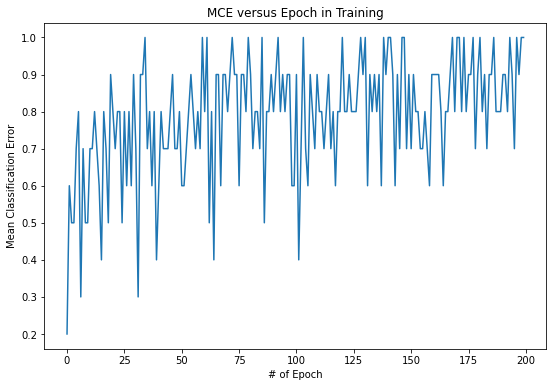

In [10]:
plt.rcParams['figure.figsize'] = (9,6)
plt.plot(net_params['Train_MCE'].values())
plt.xlabel('# of Epoch')
plt.ylabel('Mean Classification Error')
plt.title('MCE versus Epoch in Training')
plt.show()

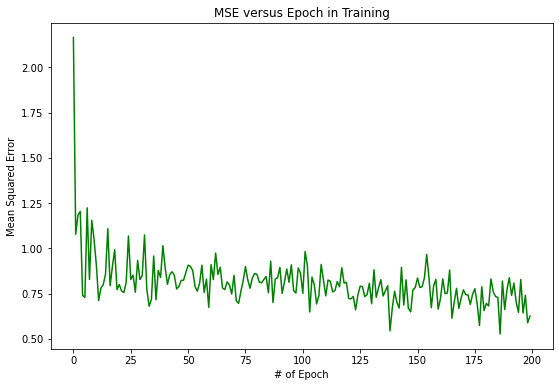

In [11]:
plt.plot(net_params['Train_MSE'].values(),color = 'green')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Training')
plt.show()

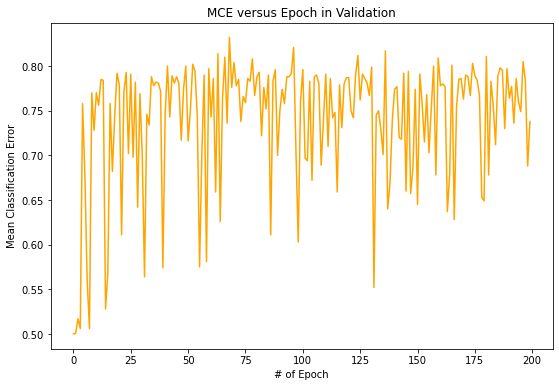

In [12]:
plt.plot(net_params['Test_MCE'].values(),color = 'orange')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Classification Error')
plt.title('MCE versus Epoch in Validation')
plt.show()


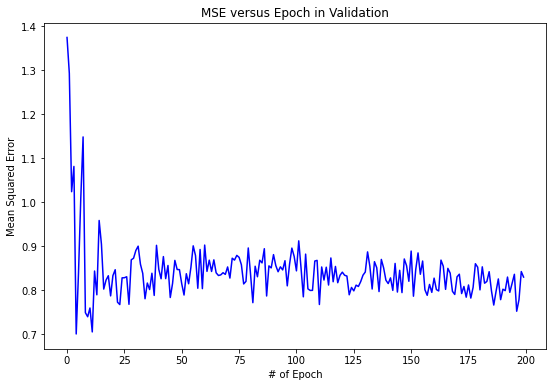

In [13]:
plt.plot(net_params['Test_MSE'].values(),color = 'blue')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Validation')
plt.show()

Part C

In [43]:
low_hidden_model = TwoLayerNetwork(input_size,batch_size,n_neurons=8,lr=1e-1)
high_hidden_model = TwoLayerNetwork(input_size,batch_size,n_neurons=152,lr=1e-1)

In [44]:
low_hidden_model.fit(X_train,y_train,X_test,y_test,epochs = 200, verbose = False)
high_hidden_model.fit(X_train,y_train,X_test,y_test,epochs =200, verbose = False)


In [45]:
low_hidden_params = low_hidden_model.parameters()
high_hidden_params = high_hidden_model.parameters()

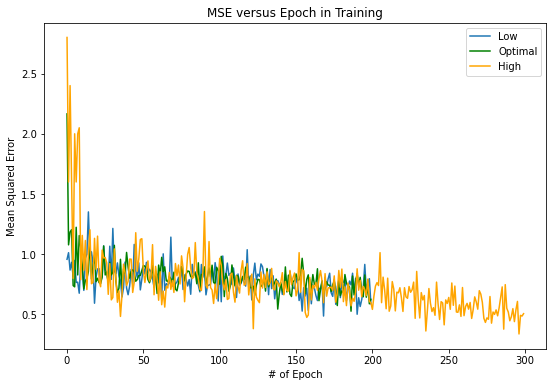

In [46]:
plt.plot(low_hidden_params['Train_MSE'].values())
plt.plot(net_params['Train_MSE'].values(),color = 'green')
plt.plot(high_hidden_params['Train_MSE'].values(),color = 'orange')
plt.legend(['Low','Optimal','High'])
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Training')
plt.show()

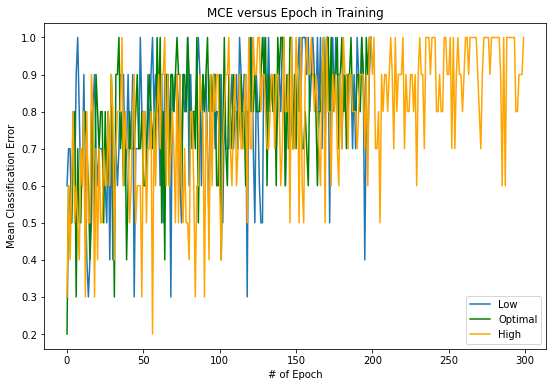

In [47]:
plt.plot(low_hidden_params['Train_MCE'].values())
plt.plot(net_params['Train_MCE'].values(),color = 'green')
plt.plot(high_hidden_params['Train_MCE'].values(),color = 'orange')
plt.legend(['Low','Optimal','High'])
plt.xlabel('# of Epoch')
plt.ylabel('Mean Classification Error')
plt.title('MCE versus Epoch in Training')
plt.show()

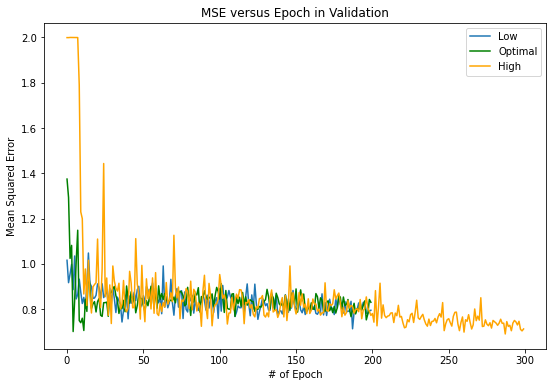

In [48]:
plt.plot(low_hidden_params['Test_MSE'].values())
plt.plot(net_params['Test_MSE'].values(),color = 'green')
plt.plot(high_hidden_params['Test_MSE'].values(),color = 'orange')
plt.legend(['Low','Optimal','High'])
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Validation')
plt.show()

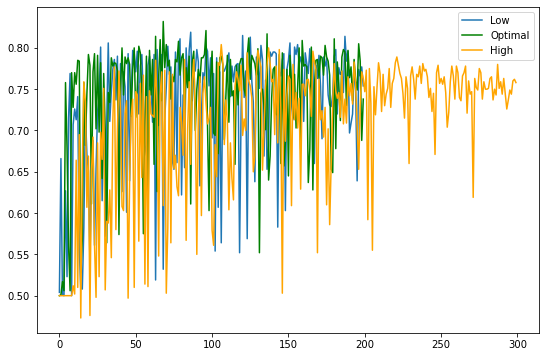

In [49]:
plt.plot(low_hidden_params['Test_MCE'].values())
plt.plot(net_params['Test_MCE'].values(),color = 'green')
plt.plot(high_hidden_params['Test_MCE'].values(),color = 'orange')
plt.legend(['Low','Optimal','High'])
plt.show()

Part D

In [8]:
class ThreeLayerNetwork:
    
    def __init__(self,input_size,batch_size,h1_neurons,h2_neurons, mean = 0,std = 1,lr =1e-1,distribution = 'Xavier'):
        np.random.seed(15)
        self.lr = lr                              
        self.mse_train = {}
        self.mce_train = {}
        self.mse_test = {}
        self.mce_test = {}
        self.prev_updates = {'W1':0,'W2':0,'W3':0,
                             'B1':0,'B2':0,'B3':0}

        self.h1_neurons = h1_neurons
        self.h2_neurons = h2_neurons
        
        self.sample_size = input_size[0]
        self.feature_size = input_size[1]
        self.batch_size = batch_size        
        self.mean,self.std = mean,std
        
        self.dist = distribution
        
        
        self.n_update = round((self.sample_size/self.batch_size))
        
        self.W1_size = self.feature_size,self.h1_neurons
        self.W2_size = self.h1_neurons,self.h2_neurons
        self.W3_size = self.h2_neurons,1
        
        self.B1_size = 1,h1_neurons
        self.B2_size = 1,h2_neurons
        self.B3_size = 1,1  
                  
       
 
                
        if (self.dist == 'Zero') :
            self.W1 = np.zeros((self.W1_size))
            self.W2 = np.zeros((self.W2_size))
            self.W3 = np.zeros((self.W3_size))
            self.B1 = np.zeros((self.B1_size))
            self.B2 = np.zeros((self.B2_size))
            self.B3 = np.zeros((self.B3_size))

        elif (self.dist == 'Gauss'):
            self.W1 = Gauss(loc = self.mean, scale = self.std, size = (self.W1_size)) * 0.01
            self.W2 = Gauss(loc = self.mean, scale = self.std, size = (self.W2_size)) * 0.01
            self.W3 = Gauss(loc = self.mean, scale = self.std, size = (self.W3_size)) * 0.01
            
            self.B1 = Gauss(loc = self.mean, scale = self.std, size = (self.B1_size)) * 0.01
            self.B2 = Gauss(loc = self.mean, scale = self.std, size = (self.B2_size)) * 0.01
            self.B3 = Gauss(loc = self.mean, scale = self.std, size = (self.B3_size)) * 0.01  

        elif (self.dist == 'He'):
            self.he_scale1 = np.sqrt(2/self.feature_size)
            self.he_scale2 = np.sqrt(2/self.h1_neurons)
            self.he_scale3 = np.sqrt(2/self.h2_neurons)
            
            self.W1 = randn(self.W1_size[0],self.W1_size[1]) * self.he_scale1
            self.W2 = randn(self.W2_size[0],self.W2_size[1]) * self.he_scale2
            self.W3 = randn(self.W2_size[0],self.W2_size[1]) * self.he_scale3
            
            self.B1 = randn(self.B1_size[0],self.B1_size[1]) * self.he_scale1
            self.B2 = randn(self.B2_size[0],self.B2_size[1]) * self.he_scale2
            self.B3 = randn(self.B3_size[0],self.B3_size[1]) * self.he_scale3

        elif (self.dist == 'Xavier'):
            self.xavier_scale1 = np.sqrt(2/(self.feature_size+self.h1_neurons))
            self.xavier_scale2 = np.sqrt(2/(self.h1_neurons+self.h2_neurons))
            self.xavier_scale3 = np.sqrt(2/(self.h2_neurons+1))

            self.W1 = randn(self.W1_size[0],self.W1_size[1]) * self.xavier_scale1
            self.W2 = randn(self.W2_size[0],self.W2_size[1]) * self.xavier_scale2
            self.W3 = randn(self.W3_size[0],self.W3_size[1]) * self.xavier_scale3
            
            self.B1 = randn(self.B1_size[0],self.B1_size[1]) * self.xavier_scale1
            self.B2 = randn(self.B2_size[0],self.B2_size[1]) * self.xavier_scale2
            self.B3 = randn(self.B3_size[0],self.B3_size[1]) * self.xavier_scale3
            

        
    def forward(self,X):        
        
        Z1 = (X @ self.W1)  + self.B1 
        A1 = np.tanh(Z1)        
        Z2 = (A1 @ self.W2) + self.B2
        A2 = np.tanh(Z2)
        Z3 = (A2 @ self.W3) + self.B3
        A3 = np.tanh(Z3)
               
        return {"Z1": Z1,"A1": A1,
                "Z2": Z2,"A2": A2,
                "Z3": Z3,"A3": A3}              
              
    
    
    def tanh(self,X):        
        return (np.exp(X) - np.exp(-X))/(np.exp(X) + np.exp(-X))

    def tanh_der(self,X):        
        return  1 - np.power(np.tanh(X),2)
    
    def backward(self,outs, X, Y):
        m = self.batch_size 
        
        Z1 = outs['Z1']
        A1 = outs['A1']
        Z2 = outs['Z2']
        A2 = outs['A2']
        Z3 = outs['Z3']
        A3 = outs['A3']
        
        
        dZ3 = (A3-Y)* self.tanh_der(Z3)
        dW3 = (1/m) * (A2.T @ dZ3)
        dB3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True) 
        
        dZ2 = np.multiply((dZ3 @ self.W3.T), self.tanh_der(Z2))
        dW2 = (1/m) * (A1.T @ dZ2)
        dB2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        
        dZ1 = np.multiply((dZ2 @ self.W2.T), self.tanh_der(Z1))
        dW1 = (1/m) * (X.T @ dZ1)
        dB1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)       
        
                
        return {"dW1": dW1, "dW2": dW2,"dW3": dW3,
                "dB1": dB1, "dB2": dB2,"dB3": dB3}  
        
    def Loss(self,pred,y_true):
        
        mse = np.square(pred-y_true).mean()
        
        pred[pred>=0]=1 
        pred[pred<0]=-1         
        
        mce = (pred == y_true).mean()*100
        
        return {'MSE':mse,'MCE':mce}
      
       
    def SGD(self,grads,momentum = False, mom_coeff = None): 
        if momentum:             
            self.W1 += (-self.lr * grads['dW1'] +  mom_coeff * self.prev_updates['W1'])       
            self.W2 += (-self.lr * grads['dW2'] +  mom_coeff * self.prev_updates['W2'])
            self.W3 += (-self.lr * grads['dW3'] +  mom_coeff * self.prev_updates['W3'])
            self.B1 += (-self.lr * grads['dB1'] +  mom_coeff * self.prev_updates['B1'])     
            self.B2 += (-self.lr * grads['dB2'] +  mom_coeff * self.prev_updates['B2'])
            self.B3 += (-self.lr * grads['dB3'] +  mom_coeff * self.prev_updates['B3'])

            self.prev_updates['W1'] = - self.lr * grads['dW1'] +  mom_coeff * self.prev_updates['W1']
            self.prev_updates['W2'] = - self.lr * grads['dW2'] +  mom_coeff * self.prev_updates['W2']
            self.prev_updates['W3'] = - self.lr * grads['dW3'] +  mom_coeff * self.prev_updates['W3']
            self.prev_updates['B1'] = - self.lr * grads['dB1'] +  mom_coeff * self.prev_updates['B1']
            self.prev_updates['B2'] = - self.lr * grads['dB2'] +  mom_coeff * self.prev_updates['B2']
            self.prev_updates['B3'] = - self.lr * grads['dB3'] +  mom_coeff * self.prev_updates['B3']
            
        else:       
            self.W1 -= self.lr * grads['dW1']        
            self.W2 -= self.lr * grads['dW2']
            self.W3 -= self.lr * grads['dW3']
            self.B1 -= self.lr * grads['dB1']        
            self.B2 -= self.lr * grads['dB2']
            self.B3 -= self.lr * grads['dB3']
        
    def fit(self,X,Y,X_test,y_test,epochs,momentum = False, mom_coeff = None,verbose=True):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
        
        
        
        for epoch in range(epochs):          
            perm = np.random.permutation(self.sample_size)
            print(f"Epoch num: {epoch}")
            for idx in range(self.n_update):
                
                
                batch_start = idx * self.batch_size
                batch_finish =(idx+1) * self.batch_size
                index = perm[batch_start:batch_finish]
                
                X_feed = X[index]    
                y_feed = Y[index]
                
                
                outs = self.forward(X_feed)              
                loss = self.Loss(outs['A3'],y_feed)
                               
                outs_test = self.forward(X_test)              
                loss_test = self.Loss(outs_test['A3'],y_test)                                

                grads = self.backward(outs,X_feed,y_feed)                
                self.SGD(grads, momentum = momentum, mom_coeff = mom_coeff)
                
            self.mse_train[f"Epoch:{epoch}"] = loss['MSE']
            self.mce_train[f"Epoch:{epoch}"] = loss['MCE']
            self.mse_test[f"Epoch:{epoch}"] = loss_test['MSE']
            self.mce_test[f"Epoch:{epoch}"] = loss_test['MCE']

            if verbose:                    
                print(f"[{epoch}/{epochs}] ------> Training :MSE: {loss['MSE']} and MCE: {loss['MCE']}")                        
                print(f"[{epoch}/{epochs}] ------> Testing  :MSE: {loss_test['MSE']} and MCE: {loss_test['MCE']}")
                

        
    def parameters(self):      
        return {'Train_MSE' : self.mse_train,               
                'Test_MSE'  : self.mse_test,
                'Train_MCE' : self.mce_train,
                'Test_MCE'  : self.mce_test}
             
             

In [9]:
mean = 0.0
std = 0.1
initialize = 'Xavier'
input_size = X_train.shape
batch_size = 18
h1_neurons = 76
h2_neurons = 380
learning_rate = 1e-1
epochs = 200

model2 = ThreeLayerNetwork(input_size,batch_size,h1_neurons,h2_neurons)

In [10]:
model2.fit(X_train,y_train,X_test,y_test,epochs)

Epoch num: 0
[0/200] ------> Training :MSE: 1.1704368185284257 and MCE: 60.0
[0/200] ------> Testing  :MSE: 1.056492358129219 and MCE: 55.7
Epoch num: 1
[1/200] ------> Training :MSE: 1.613430623685553 and MCE: 30.0
[1/200] ------> Testing  :MSE: 1.0621747850825898 and MCE: 57.199999999999996
Epoch num: 2
[2/200] ------> Training :MSE: 1.015399397476117 and MCE: 40.0
[2/200] ------> Testing  :MSE: 0.9316976825096573 and MCE: 59.4
Epoch num: 3
[3/200] ------> Training :MSE: 1.0926119860176589 and MCE: 50.0
[3/200] ------> Testing  :MSE: 0.9833537667219193 and MCE: 54.300000000000004
Epoch num: 4
[4/200] ------> Training :MSE: 1.0532599883808587 and MCE: 40.0
[4/200] ------> Testing  :MSE: 0.8938125162934455 and MCE: 61.199999999999996
Epoch num: 5
[5/200] ------> Training :MSE: 1.0288456202338017 and MCE: 50.0
[5/200] ------> Testing  :MSE: 0.9603426908410436 and MCE: 59.0
Epoch num: 6
[6/200] ------> Training :MSE: 0.961329237290373 and MCE: 60.0
[6/200] ------> Testing  :MSE: 0.954052

KeyboardInterrupt: 

In [23]:
net_params2 = model2.parameters()

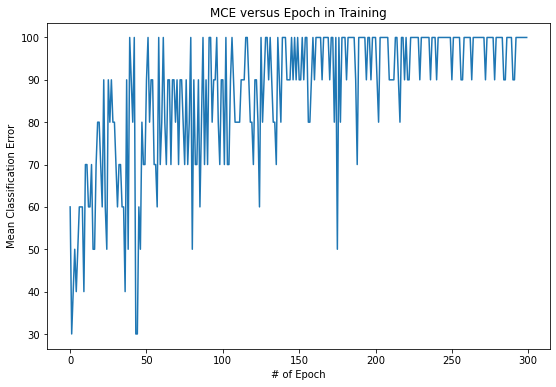

In [24]:
plt.plot(net_params2['Train_MCE'].values())
plt.xlabel('# of Epoch')
plt.ylabel('Mean Classification Error')
plt.title('MCE versus Epoch in Training')
plt.show()

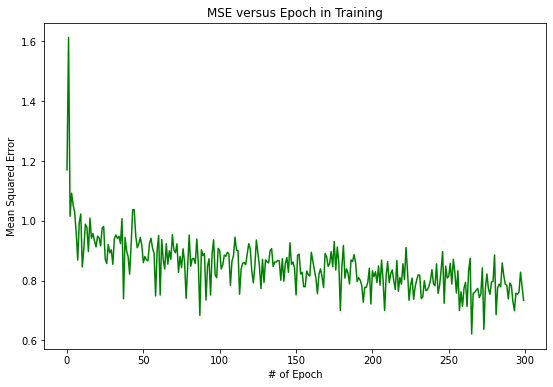

In [25]:
plt.plot(net_params2['Train_MSE'].values(),color = 'green')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Training')
plt.show()

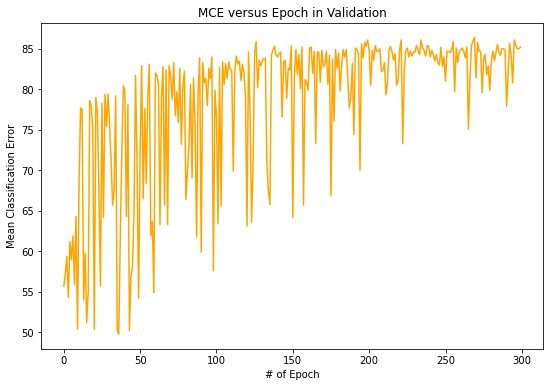

In [26]:
plt.plot(net_params2['Test_MCE'].values(),color = 'orange')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Classification Error')
plt.title('MCE versus Epoch in Validation')
plt.show()

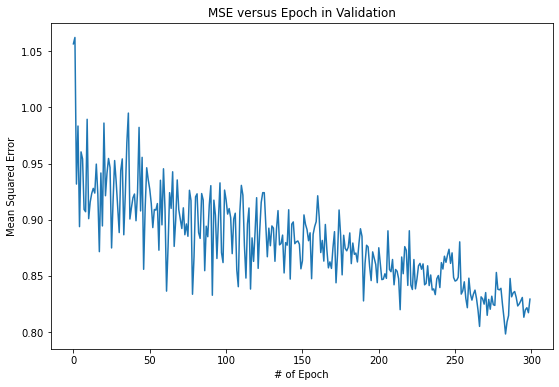

In [27]:
plt.plot(net_params2['Test_MSE'].values())
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Validation')
plt.show()

Part D

In [28]:
batch_size = 18
h1_neurons = 38
h2_neurons = 380
learning_rate = 1e-1
epochs = 200

with_mom_model = ThreeLayerNetwork(input_size,batch_size,h1_neurons,h2_neurons)

In [29]:
with_mom_model.fit(X_train,y_train,X_test,y_test,epochs, momentum = True, mom_coeff = 0.1)

[0/300] ------> Training :MSE: 0.7999256025679458 and MCE: 80.0
[0/300] ------> Testing  :MSE: 1.9997985505454148 and MCE: 50.0
[1/300] ------> Training :MSE: 1.1998480307116706 and MCE: 70.0
[1/300] ------> Testing  :MSE: 1.9996587109220778 and MCE: 50.0
[2/300] ------> Training :MSE: 1.5994444496096043 and MCE: 60.0
[2/300] ------> Testing  :MSE: 1.9989784680088407 and MCE: 50.0
[3/300] ------> Training :MSE: 2.3926077517105027 and MCE: 40.0
[3/300] ------> Testing  :MSE: 1.989411408929814 and MCE: 50.0
[4/300] ------> Training :MSE: 2.3983961798565616 and MCE: 40.0
[4/300] ------> Testing  :MSE: 1.999511867039683 and MCE: 50.0
[5/300] ------> Training :MSE: 1.9928994545893652 and MCE: 50.0
[5/300] ------> Testing  :MSE: 1.991396259507795 and MCE: 50.0
[6/300] ------> Training :MSE: 1.2728378271226783 and MCE: 50.0
[6/300] ------> Testing  :MSE: 1.3711214264446654 and MCE: 50.0
[7/300] ------> Training :MSE: 0.9080851419900708 and MCE: 60.0
[7/300] ------> Testing  :MSE: 0.9542233141

In [30]:
net_params3 = with_mom_model.parameters()

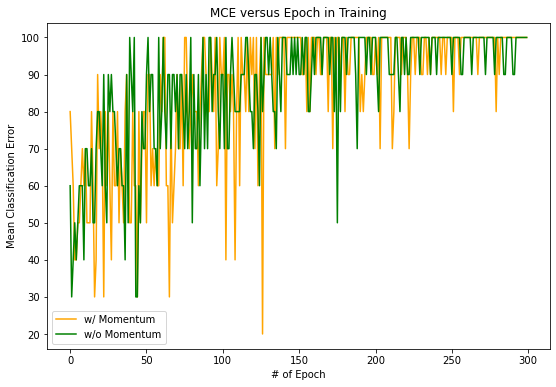

In [31]:
plt.plot(net_params3['Train_MCE'].values(),color = 'orange')
plt.plot(net_params2['Train_MCE'].values(),color = 'green')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Classification Error')
plt.title('MCE versus Epoch in Training')
plt.legend(['w/ Momentum', 'w/o Momentum'])
plt.show()

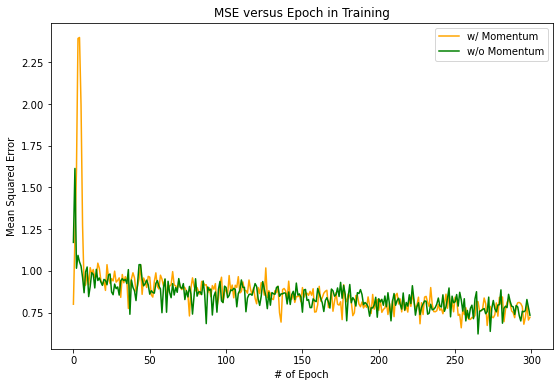

In [32]:
plt.plot(net_params3['Train_MSE'].values(),color = 'orange')
plt.plot(net_params2['Train_MSE'].values(),color = 'green')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Training')
plt.legend(['w/ Momentum', 'w/o Momentum'])
plt.show()

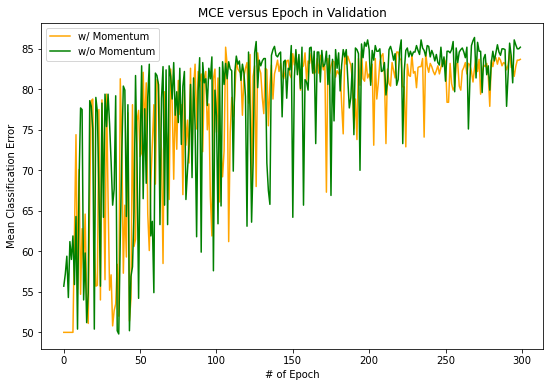

In [33]:
plt.plot(net_params3['Test_MCE'].values(),color = 'orange')
plt.plot(net_params2['Test_MCE'].values(),color = 'green')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Classification Error')
plt.title('MCE versus Epoch in Validation')
plt.legend(['w/ Momentum', 'w/o Momentum'])
plt.show()

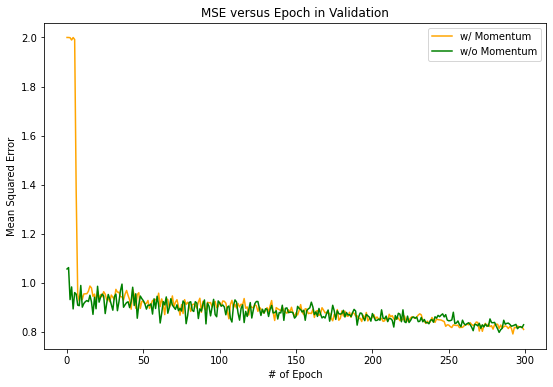

In [34]:
plt.plot(net_params3['Test_MSE'].values(),color = 'orange')
plt.plot(net_params2['Test_MSE'].values(),color = 'green')
plt.xlabel('# of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE versus Epoch in Validation')
plt.legend(['w/ Momentum', 'w/o Momentum'])
plt.show()